In [1]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, RNN, Layer, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow.keras as keras

# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ---------------------------
# Feature Loading and Scaling
# ---------------------------
input_dir = '/kaggle/input/lln-dl-6'  # Replace with the correct path
X_train = np.load(os.path.join(input_dir, 'X_train.npy'))
X_test = np.load(os.path.join(input_dir, 'X_test.npy'))
y_train = np.load(os.path.join(input_dir, 'y_train.npy'))
y_test = np.load(os.path.join(input_dir, 'y_test.npy'))
class_weight = np.load(os.path.join(input_dir, 'class_weights.npy'))
class_weight_dict = dict(enumerate(class_weight))

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

# X_train: (N, time_steps, features)
# Scale features
# Flatten to (N*time_steps, features), fit scaler, then reshape back
N, T, F = X_train.shape
X_train_reshaped = X_train.reshape(N*T, F)
X_test_reshaped = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2])

scaler = StandardScaler()
scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train_reshaped).reshape(N, T, F)
X_test_scaled = scaler.transform(X_test_reshaped).reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])




Shape of X_train: (14368, 998, 39)
Shape of X_test: (3592, 998, 39)
Shape of y_train: (14368, 4)
Shape of y_test: (3592, 4)


In [2]:
# ---------------------------
# LTC Cell Definition
# ---------------------------
def clipped_relu(x):
    return tf.keras.activations.relu(x, max_value=20.0)

def clipped_sigmoid(x):
    return tf.keras.activations.sigmoid(x) * 10.0

@keras.utils.register_keras_serializable(package="Custom", name="LTCCell")
class LTCCell(Layer):
    def __init__(self, units, ode_unfolds=6, l2_reg=0.001, **kwargs):
        super(LTCCell, self).__init__(**kwargs)
        self.units = units
        self.ode_unfolds = ode_unfolds
        self.state_size = units
        self.l2_reg = l2_reg

    def build(self, input_shape):
        self.input_dim = input_shape[-1]
        self.W = self.add_weight(
            shape=(self.input_dim + self.units, self.units),
            initializer='glorot_uniform',
            regularizer=l2(self.l2_reg),
            name='W'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            name='bias'
        )
        self.tau = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            name='tau'
        )
        self.C = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            name='C'
        )
        self.G = self.add_weight(
            shape=(self.units,),
            initializer='ones',
            name='G'
        )
        super(LTCCell, self).build(input_shape)

    def call(self, inputs, states):
        prev_state = states[0]
        concatenated = tf.concat([inputs, prev_state], axis=1)
        dt = 0.01
        for _ in range(self.ode_unfolds):
            dh = (-prev_state + tf.nn.tanh(tf.matmul(concatenated, self.W) + self.bias)) / tf.nn.softplus(self.tau)
            prev_state += dt * dh
        prev_state = clipped_relu(prev_state)
        prev_state = prev_state * clipped_sigmoid(self.C)
        prev_state = prev_state / clipped_sigmoid(self.G)
        return prev_state, [prev_state]

    def get_config(self):
        config = super(LTCCell, self).get_config()
        config.update({"units": self.units, "ode_unfolds": self.ode_unfolds, "l2_reg": self.l2_reg})
        return config


In [3]:
# ---------------------------
# Build a Deeper Liquid Neural Network Model
# ---------------------------
def build_lnn_model(input_shape, units=128, num_classes=4, l2_reg=0.0001, dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # First LTC layer (return sequences)
    ltc_cell_1 = LTCCell(units=units, ode_unfolds=6, l2_reg=l2_reg)
    x = RNN(ltc_cell_1, return_sequences=True)(inputs)

    # Second LTC layer (no return_sequences)
    ltc_cell_2 = LTCCell(units=units, ode_unfolds=6, l2_reg=l2_reg)
    x = RNN(ltc_cell_2, return_sequences=False)(x)

    # Add normalization and dropout
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    # Add multiple Dense layers for complexity
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
model = build_lnn_model(input_shape, units=32, num_classes=4, l2_reg=0.0001, dropout_rate=0.3)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 998, 39)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 998, 32)        │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_1 (RNN)                     │ (None, 32)             │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,212 (71.14 KB)

 Trainable params: 17,764 (69.39 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 113s 252ms/step - accuracy: 0.2420 - loss: 1.3847 - val_accuracy: 0.2467 - val_loss: 1.5136 - learning_rate: 3.1250e-05
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2570 - loss: 1.3843 - val_accuracy: 0.2414 - val_loss: 4.0559 - learning_rate: 3.1250e-05
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2592 - loss: 1.3846 - val_accuracy: 0.2414 - val_loss: 3.8701 - learning_rate: 3.1250e-05
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2560 - loss: 1.3844 - val_accuracy: 0.2414 - val_loss: 1.4362 - learning_rate: 3.1250e-05
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2620 - loss: 1.3849 - val_accuracy: 0.2414 - val_loss: 1.4393 - learning_rate: 3.1250e-05
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 112s 249ms/step - accuracy: 0.2537 - loss: 1.3847 - val_accuracy: 0.2414 - val_loss: 4.1342 - learning_rate: 3.1250e-05
Epoch 7/100
449/449 ━━━━━━━━━━━━━━

In [13]:
# Evaluate
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = ['angry', 'happy', 'sad', 'neutral']
print(classification_report(y_true, y_pred, target_names=target_names))

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.2395 - loss: 1.3693
Test Accuracy: 24.75%
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
              precision    recall  f1-score   support

       angry       0.25      1.00      0.40       883
       happy       0.00      0.00      0.00       476
         sad       1.00      0.01      0.01       867
     neutral       0.00      0.00      0.00      1366

    accuracy                           0.25      3592
   macro avg       0.31      0.25      0.10      3592
weighted avg       0.30      0.25      0.10      3592



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
model.save("emotion_model_615.h5")

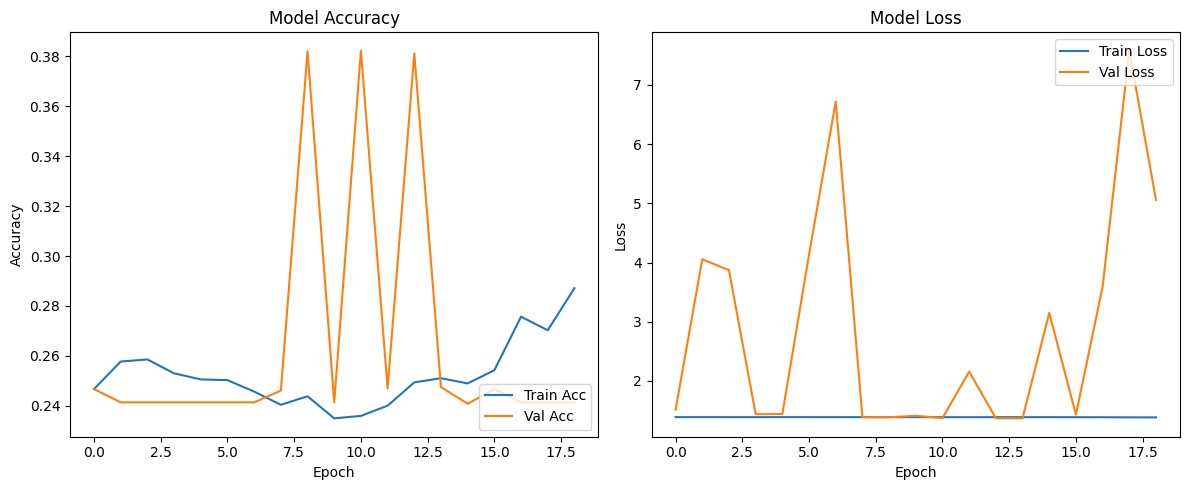

In [15]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()